# Comparing DEMs and GCPs

The workflow below doesn't consider spatial mis-alignment.

In [1]:
import xarray as xr
import rioxarray  # Enables raster support for xarray

import numpy as np
import geopandas as gpd
import pandas as pd
from pyproj import CRS

from matplotlib import pyplot as plt
import pathlib

import seaborn as sns
from scipy.stats import pearsonr

In [2]:
gcp_file = "/Users/Fangyuan/FrontierSI/Projects - Documents/Projects - Data Analytics/127 Residential Dwelling Floor Height/4 Executing/Data Exploration/Ground control/Tasmania/tasmania_survey_control_filtered_brass_pin.geojson"

In [3]:
gcps = gpd.read_file(gcp_file)
len(gcps)

62

In [4]:
dem_7cm_file = "/Users/Fangyuan/Documents/Projects/AGO/Elevation/Launceston/AGO/DEM_DSM_DTM/Source Elevation Data/AUS_Launceston_2021_DSM/dsm/launceston-dsm-7cm.vrt"
dem_28cm_file = "/Users/Fangyuan/Documents/Projects/AGO/Elevation/Launceston/AGO/DEM_DSM_DTM/Source Elevation Data/AUS_Launceston_2021_DSM/dsm/launceston-dsm-average-28cm.tif"

In [5]:
# Load DSM raster using xarray
ds_7cm = rioxarray.open_rasterio(dem_7cm_file)  # Replace with your DSM file path
ds_28cm = rioxarray.open_rasterio(dem_28cm_file)  # Replace with your DSM file path

gcps = gcps.to_crs(ds_7cm.rio.crs)
# Extract GCP coordinates
gcps_x = gcps.geometry.x
gcps_y = gcps.geometry.y
# Extract raster values at GCP locations
gcps["DSM_7cm"] = [ds_7cm.sel(x=x, y=y, method="nearest").values[0] for x, y in zip(gcps_x, gcps_y)]
gcps["DSM_28cm"] = [ds_28cm.sel(x=x, y=y, method="nearest").values[0] for x, y in zip(gcps_x, gcps_y)]

In [6]:
# AGO 1m 
dem_1m_file = "/Users/Fangyuan/Documents/Projects/AGO/Elevation/Launceston/AGO/DEM_DSM_DTM/Source Elevation Data/AUS_Tasmania_2008-19_DEM/z55/GDA94/Tamar2008_DEM_1m.vrt"
dem_1m = rioxarray.open_rasterio(dem_1m_file)
gcps_1m = gcps.to_crs(dem_1m.rio.crs)
# Extract GCP coordinates
gcps["DEM_1m"] = [dem_1m.sel(x=x, y=y, method="nearest").values[0] for x, y in zip(gcps_1m.geometry.x, gcps_1m.geometry.y)]

In [7]:
# GA 1m - 2013 - "GDA94 / MGA zone 55" ("EPSG:28355")
ga_1m_file = "/Users/Fangyuan/Library/CloudStorage/OneDrive-SharedLibraries-FrontierSI/Projects - Documents/Projects - Data Analytics/127 Residential Dwelling Floor Height/4 Executing/GA_data_documentation/Launceston DEM/1m_DEM.vrt"
ga_1m = rioxarray.open_rasterio(ga_1m_file)
gcps_ga = gcps.to_crs(ga_1m.rio.crs)
# Extract GCP coordinates
gcps["DEM_GA_1m"] = [ga_1m.sel(x=x, y=y, method="nearest").values[0] for x, y in zip(gcps_ga.geometry.x, gcps_ga.geometry.y)]


In [16]:
# GA 5m
ga_5m_file = "/Users/Fangyuan/Library/CloudStorage/OneDrive-SharedLibraries-FrontierSI/Projects - Documents/Projects - Data Analytics/127 Residential Dwelling Floor Height/4 Executing/GA_data_documentation/Launceston DEM/5m_DEM_70570/5m_DEM.tif"
ga_5m = rioxarray.open_rasterio(ga_5m_file)
gcps_5m = gcps.to_crs(ga_5m.rio.crs)
# Extract GCP coordinates
gcps["DEM_GA_5m"] = [ga_5m.sel(x=x, y=y, method="nearest").values[0] for x, y in zip(gcps_5m.geometry.x, gcps_5m.geometry.y)]


In [8]:
gcps.head()

,PACK_ID,SCS_NAME,MGA_ZONE,GDA2020_E,GDA2020_N,GDA2020_PU,PU_METHOD,HEIGHT,HGT_DATUM,HGT_CLASS,...,HOR_ORDER,TARGET_STR,MARKSTATUS,DESCRIPT,ORDER_SYMB,geometry,DSM_7cm,DSM_28cm,DEM_1m,DEM_GA_1m
0,DSM1116-06,None,55,511510.813,5416656.015,0.023,Rigorous,27.747,AHD83,GPS,...,2ND,None,EXISTING,Brass pin in concrete block with coverbox over.,purpletriangle,POINT (511510.813 5416656.015),28.126617,28.125149,27.790001,27.610001
1,DSM0912-37,None,55,509672.159,5413082.811,0.022,Rigorous,92.922,AHD83,LEV3,...,2ND,None,EXISTING,Brass pin in coverbox,purpletriangle,POINT (509672.159 5413082.811),93.124062,93.149338,92.419998,92.680000
2,DSM0913-14,None,55,509895.799,5413720.481,0.016,Rigorous,4.532,AHD83,LEV3,...,2ND,None,EXISTING,Brass pin in concrete with cover box.,purpletriangle,POINT (509895.799 5413720.481),4.804619,4.816874,4.330000,4.290000
3,DSM1213-18,None,55,512175.215,5413646.337,0.017,Rigorous,1.619,AHD83,GPS,...,2ND,None,EXISTING,Brass pin in concrete block with coverbox over.,purpletriangle,POINT (512175.215 5413646.337),2.145104,2.131727,1.600000,1.720000
4,DSM1312-08,None,55,513868.432,5412373.961,0.040,Estimated,5.885,AHD83,LEV3,...,2ND,None,EXISTING,Brass pin in concrete with cover box. NOTE: Th...,purpletriangle,POINT (513868.432 5412373.961),6.334414,6.339547,5.600000,5.560000


In [9]:

def compare_cols(col1, col2):
    # Compute offset (difference)
    offset = gcps[col1] - gcps[col2]
    # Compute IQR (Interquartile Range) for Outlier Removal
    Q1 = offset.quantile(0.25)
    Q3 = offset.quantile(0.75)
    IQR = Q3 - Q1
    # Define outlier thresholds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    keep = (offset >=lower_bound) & (offset <=upper_bound)

    print(f"{len(offset) - keep.sum()} outliers removed from {len(offset)} pairs")

    mean_offset = np.mean(offset[keep])
    std_offset = np.std(offset[keep])

    # Compute RMSE
    rmse = np.sqrt(np.mean((offset[keep]-mean_offset)** 2))

    # Compute MAE
    mae = np.mean(np.abs((offset[keep]-mean_offset)))

    # Compute correlation
    cor, p_value = pearsonr(gcps[col1][keep], gcps[col2][keep])

    print(f"Correlation Between {col1} and {col2}: {cor:.3f}")
    print(f"offset mean and std: {mean_offset:.3f}, {std_offset:.3f}")
    print(f"rmse: {rmse:.3f}, mae: {mae:.3f}")

    # Plot scatter plot with regression line
    plt.figure(figsize=(8, 6))
    sns.regplot(x=gcps[col1][keep], y=gcps[col2][keep], scatter_kws={'s': 10}, line_kws={"color": "red"})

    # Add labels and title
    plt.xlabel(f"{col1}")
    plt.ylabel(f"{col2}")
    plt.title(f"Correlation Between {col1} and {col2}(r={cor:.3f})");

3 outliers removed from 62 pairs
Correlation Between HEIGHT and DEM_GA_1m: 1.000
offset mean and std: 0.062, 0.161
rmse: 0.161, mae: 0.129


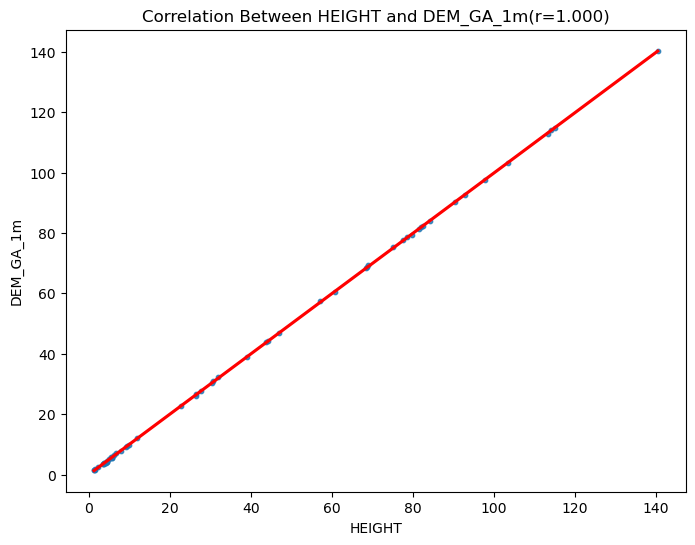

In [10]:
compare_cols("HEIGHT", "DEM_GA_1m")

10 outliers removed from 62 pairs
Correlation Between HEIGHT and DEM_GA_5m: 1.000
offset mean and std: 0.029, 0.187
rmse: 0.187, mae: 0.141


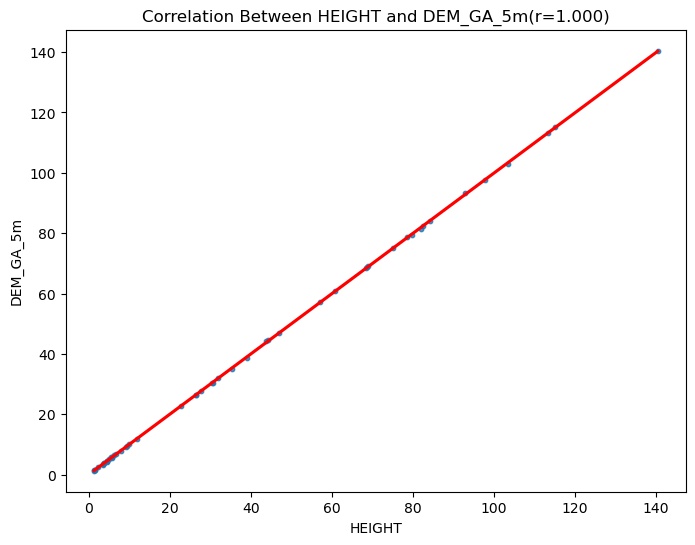

In [17]:
compare_cols("HEIGHT", "DEM_GA_5m")

12 outliers removed from 62 pairs
Correlation Between HEIGHT and DSM_7cm: 1.000
offset mean and std: -0.387, 0.093
rmse: 0.093, mae: 0.076


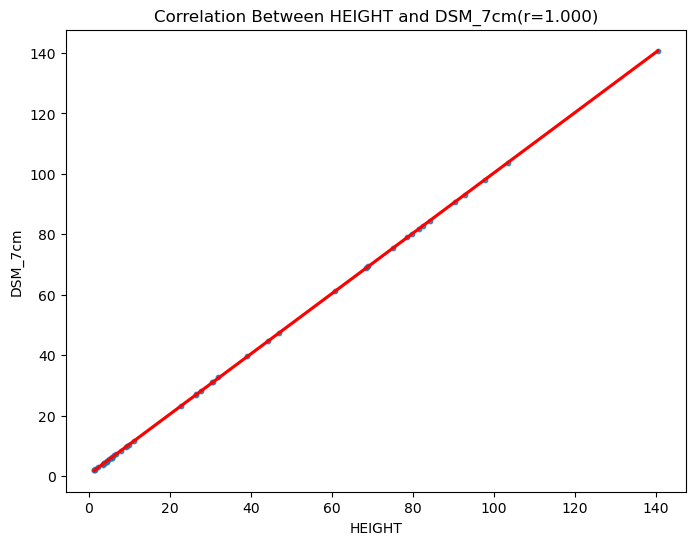

In [11]:
compare_cols("HEIGHT", "DSM_7cm")

12 outliers removed from 62 pairs
Correlation Between HEIGHT and DEM_1m: 1.000
offset mean and std: 0.089, 0.165
rmse: 0.165, mae: 0.121


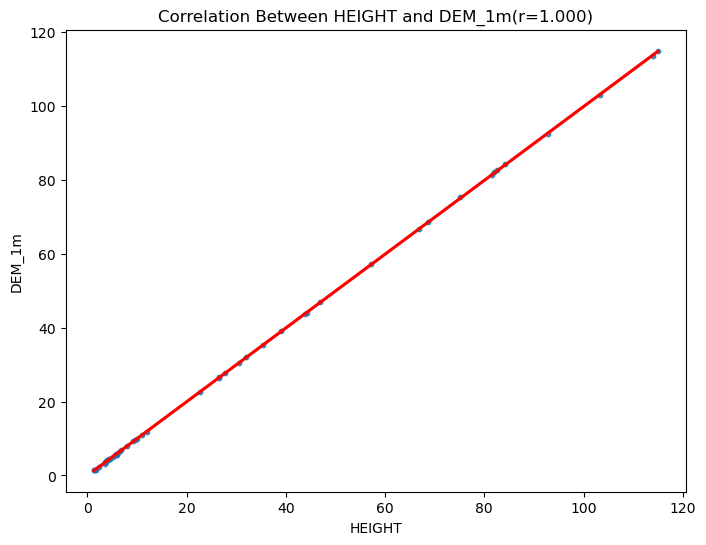

In [12]:
compare_cols("HEIGHT", "DEM_1m")

13 outliers removed from 62 pairs
Correlation Between DSM_7cm and DEM_1m: 1.000
offset mean and std: 0.579, 0.497
rmse: 0.497, mae: 0.298


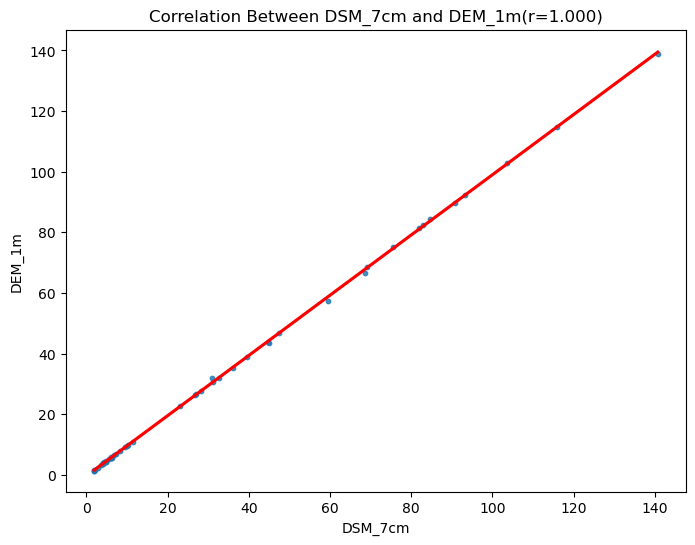

In [13]:
compare_cols("DSM_7cm", "DEM_1m")